# **Pulsar Star Project**

### Group 144

Authors:
* Chadd Hennig, 37879814
* Jenni Tong, 23988835
* Jincheng Hong, 16879926
* Susan Liu, 25691544




## Introduction

Pulsar detection is a significant endeavour within astrophysics, as it provides scientists with a deeper understanding of the cosmos. Specifically, the discovery of pulsars provides information about certain timelines in the universe, as well as information about the interstellar medium itself. Pulsars are the remains of a collapsed star— also known as neutron stars. Such neutron stars produce radio emissions, which lies as the basis for pulsar discovery. Specifically, pulsar rotation results in a distinct radio emission pattern, which instruments on earth can then detect to confirm the pulsar’s existence. The issue, however, is that there are various celestial objects that produce detectable radio emissions. For instance, celestial objects such as quasars, supernovae, etc. all release radio emissions much like pulsars.  

Therefore, this project assesses the question of classifying whether or not certain emission patterns are actually from pulsars, through the analysis of factors beyond simply the detection of radio emissions. Such factors, which will be visualized later in this report, include profile mean, profile skewness, and profile kurtosis. These statistical features allow for the distinction between pulsar and non-pulsar candidates.  

To approach this classification, this project utilizes the HTRU2 data set, which features a sample of various pulsar candidates. An analysis of the HTRU2 data set will allow us to predict which pulsar candidates are truly pulsars.


## Methods & Results

This study incorporates $k$-nn classification.

First we determined the variables that had the strongest relationships with pulsar stars, and made them as the predictors.

Steps to our exploratory data analysis: 

1. Create Recipe  
    Created a recipe with `class` ~ predictors above.  
    Used `step_scale()` and `step_center()` to scale and centre the 5 variables.

    
2. Cross-Validate the data  
    Used the training data to create a k-nearest-neighbor model that performs a 5-fold cross-validation.
    
    
3. Created a Workflow to get ideal *K*  
    Created a workflow to fit the 5-fold data in, through this data we chose an ideal *K*.

4. Workflow and Fit  
    Created a workflow to fit all training data.
    
5. Used our classifier to predict the testing data `pulsar_test`

6. Evaluate our model  
    Created a table to show the accuracy of our model using the `metrics()`, then compare.

7. Visualize results
    Created a plot colored by the true class and a plot colored by the class predicted by our model for each pair of predictors, then compare.
    

### 1. Loads Data

In [1]:
install.packages("themis")

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
#load library
library(tidyverse)
library(repr)
library(digest)
library(cowplot)
library(tidymodels)

library(themis)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
# Read in the data set
pulsar <- read_csv('https://raw.githubusercontent.com/susanyliu/dsci100-project144/main/data/HTRU_2.csv', col_names = FALSE)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 2. Cleaning and Wrangling

In [4]:
# Add column names
colnames(pulsar) <- c('Profile_mean', 'Profile_stdev', 'Profile_skewness', 'Profile_kurtosis', 
                      'DM_mean', 'DM_stdev', 'DM_skewness', 'DM_kurtosis', 'class')

In [5]:
# Changed the column "Class" into factor
pulsar_class <- pulsar |>
    pull(class)

pulsar <-  pulsar |>
    mutate(class = ifelse(pulsar_class, "Pulsar", "Non_Pulsar")) |>
    mutate(class = as_factor(class))

In [6]:
#set seed
set.seed(144)

# split data into 75% training and 25% testing
pulsar_split <- initial_split(pulsar, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

In [7]:
#print the first 5 observations of the pulsar data
paste("Table 1")
head(pulsar, n = 5)

[1] "Table 1"

Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,Non_Pulsar
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,Non_Pulsar
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,Non_Pulsar
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,Non_Pulsar
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,Non_Pulsar


### 3. Summarize the Data

To have a overview of our data(training data), we  
1. summarized the mean value for each predictor  
2. counted the number of observations for each class.  

Note: there is no missing values.

In [8]:
#summarize and create a table
predictor_mean <- pulsar_train |>
    group_by(class) |>
    summarize(Profile_mean = mean(Profile_mean) , Profile_stdev = mean(Profile_stdev),
              Profile_skewness = mean(Profile_skewness),Profile_kurtosis = mean(Profile_kurtosis),
              DM_mean = mean(DM_mean),n=n())

paste("Table 2")

predictor_mean

[1] "Table 2"

class,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Non_Pulsar,116.56174,47.32295,0.2111174,0.378781,8.722467,12235
Pulsar,56.93468,38.70407,3.1311589,15.618123,50.268911,1188


In our summarized table, columns 2-6 represents the mean value of that variable 
(e.g. the data column `Profile_stdev` represent the mean value of Profile standard deviation of Non Pulsar Stars and Pulsar Stars)

Column `n` represents the number of observations in that class.

In [9]:
paste("Table 3")
predictor_mean

[1] "Table 3"

class,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Non_Pulsar,116.56174,47.32295,0.2111174,0.378781,8.722467,12235
Pulsar,56.93468,38.70407,3.1311589,15.618123,50.268911,1188


### 4. Visualize the Data

To find which variables are relevant to distinguish a pulsar star, we created several scatter plots between variables and colored them according to their classes.

In [10]:
#plot to see related variables
plot1.2 <- pulsar_train|>
    ggplot(aes(x = Profile_mean, y= Profile_stdev, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Mean of the integrated profile', y = 'Standard deviation of the integrated profile', color = "Is pulsar?")

plot1.3 <- pulsar_train|>
    ggplot(aes(x = Profile_mean, y= Profile_skewness, color = class))+
    geom_point(alpha = 0.6)+
    ggtitle("Figure 1") +
    labs(x = 'Mean of the integrated profile', y = 'Excess kurtosis of the integrated profile', color = "Is pulsar?")

plot1.4 <- pulsar_train|>
    ggplot(aes(x = Profile_mean, y= Profile_skewness, color = class))+
    geom_point(alpha = 0.6)+
    ggtitle("Figure 3") +
    labs(x = 'Mean of the integrated profile', y = 'Skewness of the integrated profile', color = "Is pulsar?")

plot2.3 <- pulsar_train|>
    ggplot(aes(x = Profile_stdev, y= Profile_skewness, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Standard deviation of the integrated profile', y = 'Excess kurtosis of the integrated profile', color = "Is pulsar?")

plot2.4 <- pulsar_train|>
    ggplot(aes(x = Profile_stdev, y= Profile_kurtosis, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Standard deviation of the integrated profile', y = 'Skewness of the integrated profile', color = "Is pulsar?")

plot2.5 <- pulsar_train|>
    ggplot(aes(x = Profile_stdev, y= DM_mean, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Standard deviation of the integrated profile', y = 'Mean of the DM-SNR curve', color = "Is pulsar?")

plot3.4 <- pulsar_train|>
    ggplot(aes(x = Profile_skewness, y = Profile_kurtosis, color = class))+
    geom_point(alpha = 0.6)+
    ggtitle("Figure 2") +
    labs(x = 'Excess kurtosis of the integrated profile', y = 'Skewness of the integrated profile', color = "Is pulsar?")

plot3.5 <- pulsar_train|>
    ggplot(aes(x = Profile_skewness, y= DM_mean, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Excess kurtosis of the integrated profile', y = 'Mean of the DM-SNR curve', color = "Is pulsar?")

plot4.5 <- pulsar_train|>
    ggplot(aes(x = Profile_kurtosis, y = DM_mean, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Skewness of the integrated profile', y = 'Mean of the DM-SNR curve', color = "Is pulsar?")

plot5.6 <- pulsar_train|>
    ggplot(aes(x = DM_mean, y= DM_stdev, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Mean of the DM-SNR curve', y = 'Standard deviation of the DM-SNR curve', color = "Is pulsar?")

plot6.7 <- pulsar_train|>
    ggplot(aes(x = DM_stdev, y= DM_skewness, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Standard deviation of the DM-SNR curve', y = 'Excess kurtosis of the DM-SNR curve', color = "Is pulsar?")

plot7.8 <- pulsar_train|>
    ggplot(aes(x = DM_skewness, y= DM_kurtosis, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Excess kurtosis of the DM-SNR curve', y = 'Skewness of the DM-SNR curve', color = "Is pulsar?")

We analyzed the plots above and found that: pulsar stars tend to have **low** mean of the integrated profile, **high** excess kurtosis of the integrated profile, and **high** skewness of the integrated profile.

Below are plots showing these relationships.

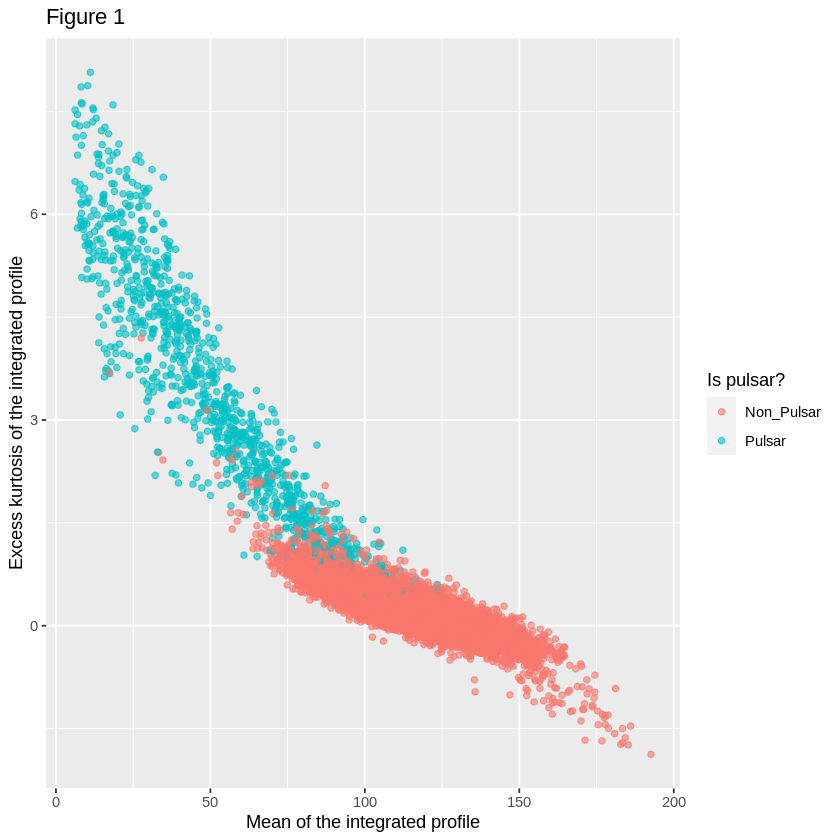

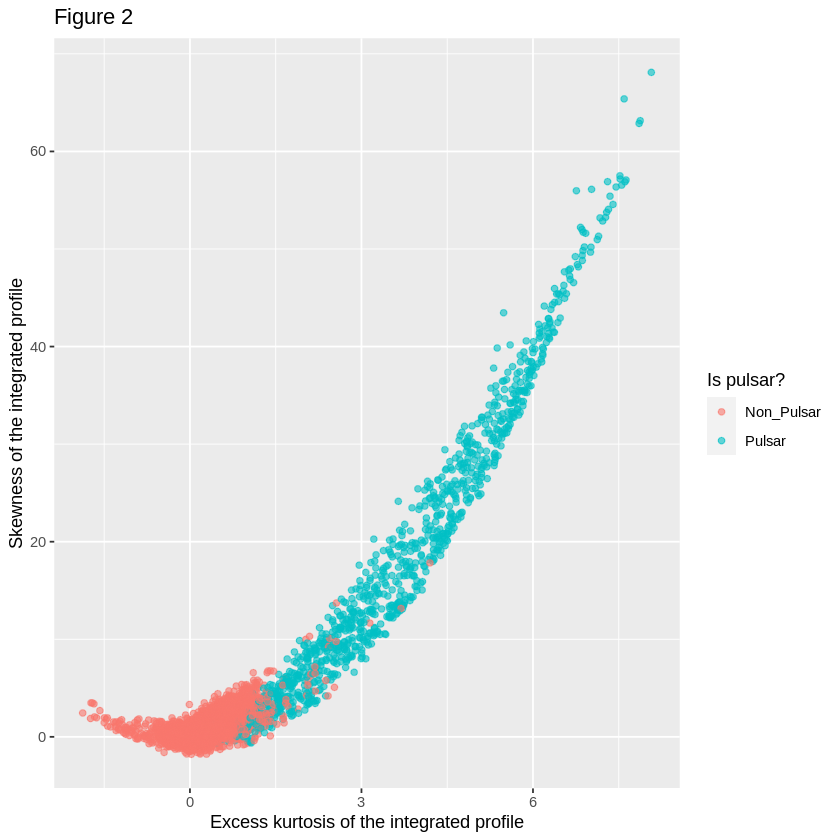

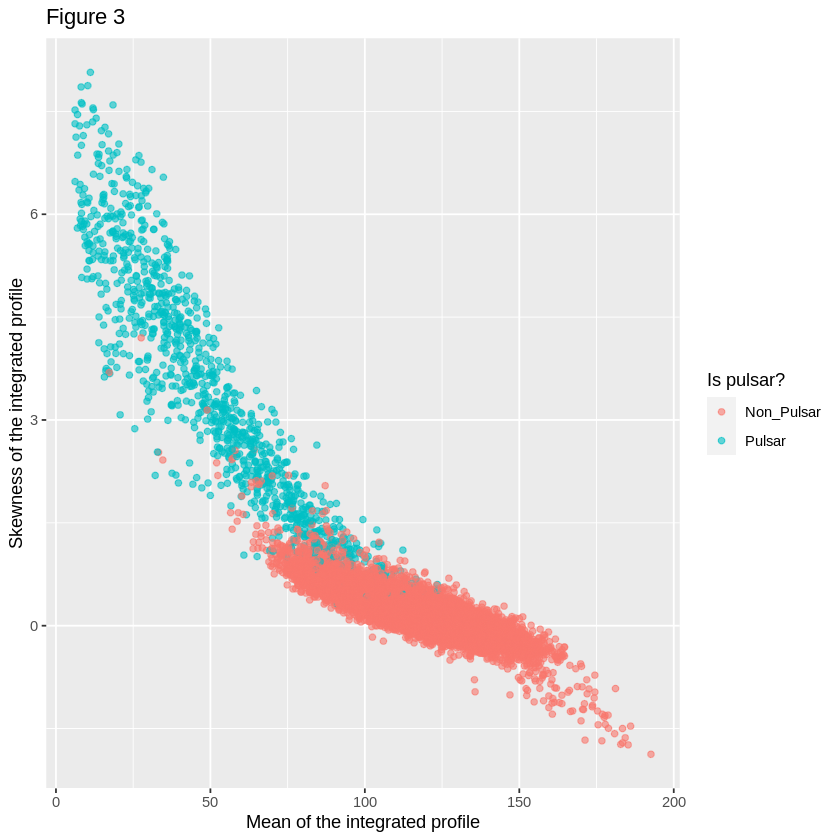

In [11]:
plot1.3
plot3.4
plot1.4

Therefore, we chose `Profile_mean`, `Profile_skewness`, `Profile_kurtosis` as predictors.

### 5. Perform the data analysis using $k$-nn

In [12]:
set.seed(144)

# create "up_sample" recipe 
pulsar_wee <- recipe(class ~ Profile_mean + Profile_skewness + 
                        Profile_kurtosis, data = pulsar_train) |>
     step_upsample(class, over_ratio = 1, skip = FALSE) |>
     prep() |>
     bake(pulsar_train)

pulsar_recipe <- recipe(class ~ Profile_mean + Profile_skewness + 
                        Profile_kurtosis, data = pulsar_wee) |>
     step_scale(all_predictors()) |>
     step_center(all_predictors())

In [13]:
set.seed(144)

# cross-validate
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = class)

In [14]:
set.seed(144)

# create model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

In [15]:
set.seed(144)

k_vals = tibble(neighbors = seq(from = 1, to = 10, by = 1))

# tune grid and find accuracies
knn_results <- workflow() |>
     add_recipe(pulsar_recipe) |>
     add_model(knn_spec) |>
     tune_grid(resamples = pulsar_vfold, grid = k_vals) |>
     collect_metrics() 

In [16]:
accuracies <- knn_results |>
     filter(.metric == "accuracy")

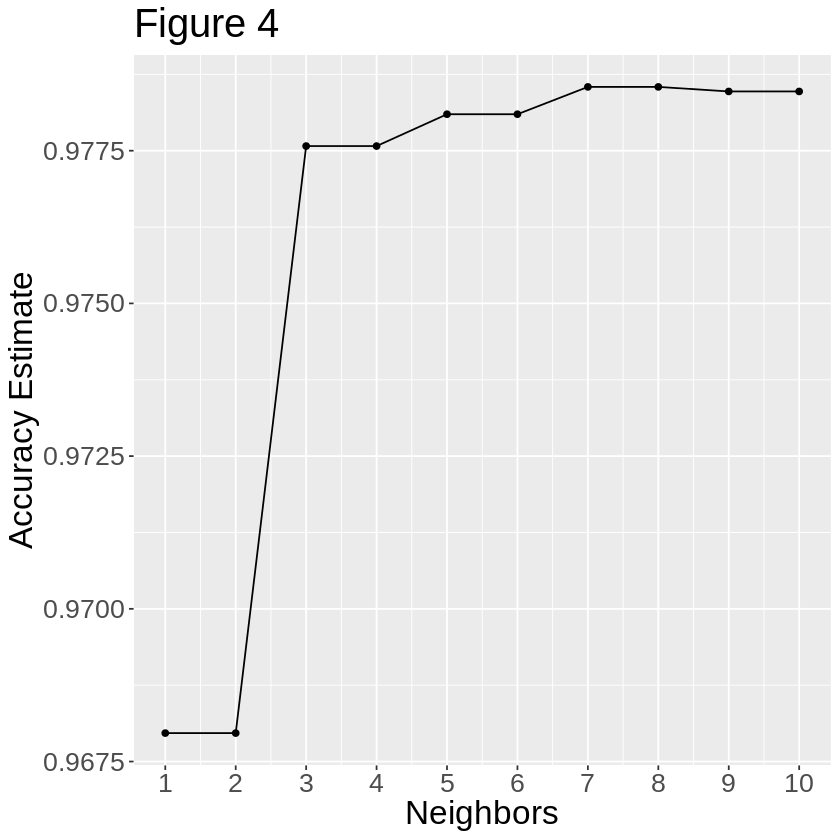

In [17]:
# plot to find best k
cross_val_plot <- accuracies |>
       ggplot(aes(x = neighbors, y = mean)) +
       geom_point() +
       geom_line() +
       scale_x_continuous(breaks = 1:10) +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Figure 4")+
       theme(text = element_text(size = 20)) 

cross_val_plot

We chose $k = 7$ because it has the best estimated accuracy.

In [18]:
set.seed(144)

# create model using the best k
pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
       set_engine("kknn") |>
       set_mode("classification")

# fit with the training data
pulsar_fit <- workflow() |>
       add_recipe(pulsar_recipe) |>
       add_model(pulsar_spec) |>
       fit(data = pulsar_train)

In [19]:
# predict the testing data
pulsar_predictions <- predict(pulsar_fit, pulsar_test) |>
          bind_cols(pulsar_test)

pulsar_metrics <- pulsar_predictions |>
          metrics(truth = class, estimate = .pred_class) |> 
          filter(.metric == "accuracy")

pulsar_conf_mat <- pulsar_predictions|>
          conf_mat(truth = class, estimate = .pred_class)

paste("Table 4")
pulsar_metrics

paste("Table 5")
pulsar_conf_mat
# pulsar_predictions

[1] "Table 4"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9787709


[1] "Table 5"

            Truth
Prediction   Non_Pulsar Pulsar
  Non_Pulsar       3999     70
  Pulsar             25    381

The model does a really good job of predicting since it has an accuracy of 97.9%. However, this high accuracy may be because the data is unbalanced: we have found that there are way more non pulsar stars than pulsar stars; even if the machine predicts every star to be non pulsar, it would have a 90% accuracy. But since we have upsampled the training data, the set is better trained.

By using a confusion matrix to have a closer look at our predictions and consider only for "true pulsar stars", we can see that while 381 were predicted correctly as pulsar, 70 were predicted incorrectly as non-pulsar, thus having a 84.5% of accuracy for true pulsar stars.

### 6. Visualization of the Analysis

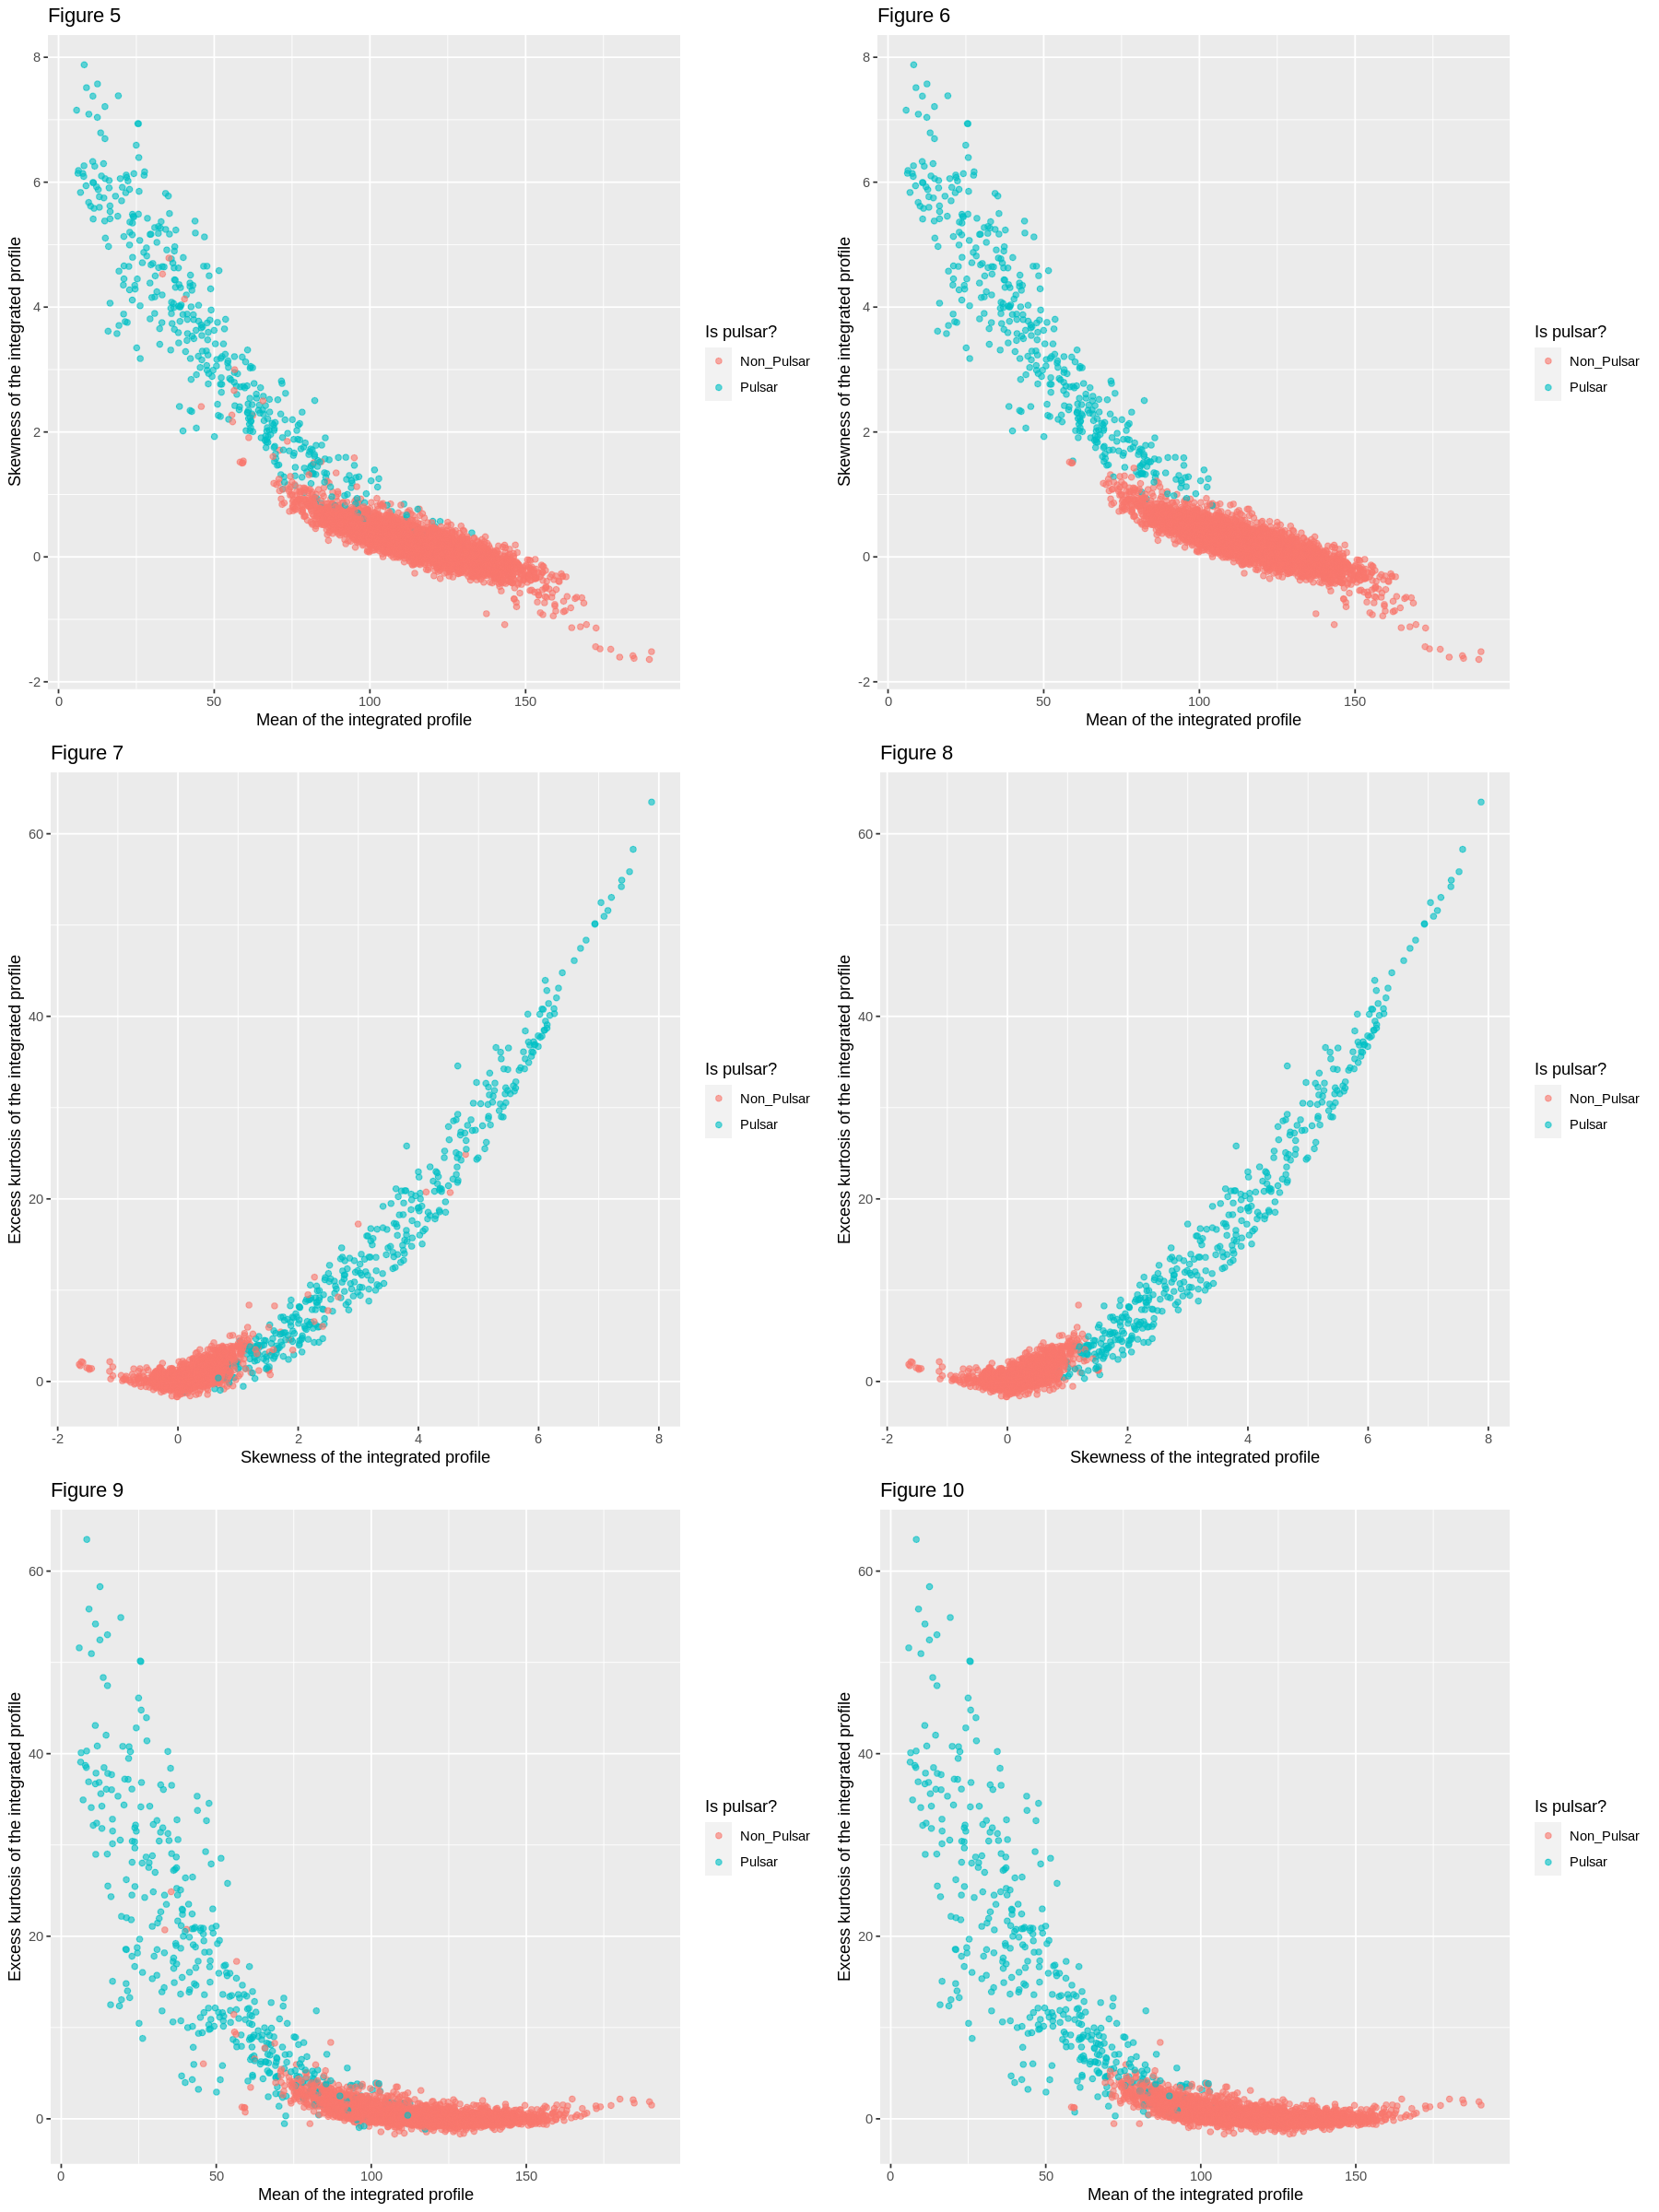

In [20]:
testplot1.3 <- pulsar_predictions |>
    ggplot(aes(x = Profile_mean, y= Profile_skewness, color = class))+
    geom_point(alpha = 0.6)+
    ggtitle("Figure 5")+
    labs(x = 'Mean of the integrated profile', y = 'Skewness of the integrated profile', color = "Is pulsar?")

testplot1.3_pred <- pulsar_predictions |>
    ggplot(aes(x = Profile_mean, y= Profile_skewness, color = .pred_class))+
    geom_point(alpha = 0.6)+
    ggtitle("Figure 6")+
    labs(x = 'Mean of the integrated profile', y = 'Skewness of the integrated profile', color = "Is pulsar?")

testplot3.4 <- pulsar_predictions |>
    ggplot(aes(x = Profile_skewness, y= Profile_kurtosis, color = class))+
    geom_point(alpha = 0.6)+
    ggtitle("Figure 7")+
    labs(x = 'Skewness of the integrated profile', y = 'Excess kurtosis of the integrated profile', color = "Is pulsar?")

testplot3.4_pred <- pulsar_predictions |>
    ggplot(aes(x = Profile_skewness, y= Profile_kurtosis, color = .pred_class))+
    geom_point(alpha = 0.6)+
    ggtitle("Figure 8")+
    labs(x = 'Skewness of the integrated profile', y = 'Excess kurtosis of the integrated profile', color = "Is pulsar?")

testplot1.4 <- pulsar_predictions |>
    ggplot(aes(x = Profile_mean, y= Profile_kurtosis, color = class))+
    geom_point(alpha = 0.6)+
    ggtitle("Figure 9")+
    labs(x = 'Mean of the integrated profile', y = 'Excess kurtosis of the integrated profile', color = "Is pulsar?")

testplot1.4_pred <- pulsar_predictions |>
    ggplot(aes(x = Profile_mean, y= Profile_kurtosis, color = .pred_class))+
    geom_point(alpha = 0.6)+
    ggtitle("Figure 10")+
    labs(x = 'Mean of the integrated profile', y = 'Excess kurtosis of the integrated profile', color = "Is pulsar?")

options(repr.plot.width = 15, repr.plot.height = 20)
plot_grid(testplot1.3, testplot1.3_pred,
          testplot3.4, testplot3.4_pred,
          testplot1.4, testplot1.4_pred, ncol = 2)

From the plots, it shows that our trained model is overall very similar to the original model, but it does NOT do well in handling the "outliers" for each class (e.g., our trained model identifies pulsar stars that fall in the area of non pulsar stars as non pulsar).

## Discussion

Through this exploratory data analysis, we have found that just as we had originally predicted, there were significantly more candidates that were non-pulsar (4069 non-pulsar stars) than ones that were pulsar (406). This conclusion was reached through an extensive analysis of our visualizations we had created and our confusion matrix, which illustrates the number of non-pulsar/pulsar stars that were predicted as candidates.   

As previously mentioned, these results align with our original prediction that there would be more non-pulsars than pulsars. This prediction was based on the premise that there are a variety of interstellar objects which release radio emissions. Thus, of the candidates within this data set, we believed it to be more plausible for a majority of them to be non-pulsars. 

Another finding is that pulsar stars usually have a low profile mean, high profile skewness, and high profile kurtosis. However, their are some "outliers" for each class: few number of pulsars fall in the region of non pulsar stars, therefore give difficulties for our model to predict correctly. We can argue that pulsar stars are special and case-by-case, a general model can not ensure 100% correctness of predicting a pulsar star. Pulsar stars should be checked manually if people want to be sure.

The significance of this outcome is crucial in making further progress in the astrophysics field. Once candidates are classified as pulsars, scientists can hone in on these samples and learn more about their origins and behaviour — providing information about stellar collapse and even about planets beyond the solar system we live in. It is also significant because the classification of these candidates will provide a glimpse into the reality of pulsar existence, and more precisely pulsar abundance.  

With this information, further research may address certain questions regarding pulsars. Questions may include: why is there outliers in pulsar stars? What relationship exists between pulsar existence and extraterrestrial life? What factors most accurately indicate between pulsars and non-pulsars? Ultimately, the findings of this data classification will be significant in the realm of astrophysics.

## References

Cofield, C. (2016, April 22). What are pulsars? Space.com. Retrieved November 28, 2022, from https://www.space.com/32661-pulsars.html

HTRU2 Data Set. UCI Machine Learning Repository: HTRU2 data set. (n.d.). Retrieved November 28, 2022, from https://archive.ics.uci.edu/ml/datasets/HTRU2

Pulsars astronomy. National Radio Astronomy Observatory. (2022, January 25). Retrieved November 28, 2022, from https://public.nrao.edu/radio-astronomy/pulsars/ 

R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656 

Zhang, C. J., Shang, Z. H., Chen, W. M., Xie, L., & Miao, X. H. (2020). A review of Research on Pulsar candidate recognition based on machine learning. Procedia Computer Science, 166, 534–538. https://doi.org/10.1016/j.procs.2020.02.050
